# 0.0 Imports

In [1]:
import math
import inflection
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

from IPython.core.display import HTML
from IPython.display import Image

import datetime

from scipy import stats as ss

pd.__version__

'1.3.4'

## 0.1 Helper Functions

## 0.2 Loading Data

In [2]:
# Raw seria a marcação de arquivo que não foi limpo ainda (acabou de ler)
df_sales_raw = pd.read_csv("train.csv",low_memory = False)
df_store_raw = pd.read_csv("store.csv",low_memory = False)

In [3]:
# Merge (método da classe pandas) 1arg- documento que será referencia 2arg- arquivo que será anexado how:como fará e on a coluna em comum
df_raw = pd.merge(df_sales_raw, df_store_raw, how="left", on="Store")

# 1.0 Descrição dos Dados (Passo 1)

In [4]:
#fazer cópia dos dados, para não usar em cima do original
df1 = df_raw.copy()

In [5]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1 Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

# função para deixar a lista em minúsculo e em snakecase(_)
snakecase = lambda x: inflection.underscore (x)
cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

In [7]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [8]:
print ("Number of Rows:{}".format(df1.shape[0]))
print ("Number of Cols:{}".format(df1.shape[1]))

Number of Rows:1017209
Number of Cols:18


## 1.3 Data Types

In [9]:
# mudar a data de object para forma de data
df1["date"] = pd.to_datetime(df1["date"])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA (Substituindo os dados faltantes)

In [11]:
### 3 formas de tratar os "na"
### 1- exclui, mas perde informação
### 2- ML para substituição no comportameno da coluna (Mediana ou media clusterização ou predição dos valores vazios)
### 3-pensar no negócio (pq gerou o NA)

In [12]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
361298,678,3,2014-08-20,7814,876,1,1,0,0,c,a,3250.0,NaN,NaN,1,40.0,2011.0,"Jan,Apr,Jul,Oct"


In [13]:
df1["competition_distance"].max()

75860.0

In [14]:
#competition_distance colocar 0 no lugar de NA Lambda é assim pq só tem 1 coluna
df1["competition_distance"] = df1["competition_distance"].apply (lambda x:200000.0 if math.isnan(x) else x)

#competition_open_since_month aqui aplica assim pq tem mais de uma coluna para analisar (por isso o Axis:1, se fosse axis 0 seria ao longo da linha)
df1["competition_open_since_month"] = df1.apply(lambda x: x["date"].month if math.isnan( x["competition_open_since_month"]) else x["competition_open_since_month"], axis=1)

#competition_open_since_year
df1["competition_open_since_year"] = df1.apply(lambda x: x["date"].year if math.isnan( x["competition_open_since_year"]) else x["competition_open_since_year"], axis=1)

#promo2_since_week
df1["promo2_since_week"] = df1.apply(lambda x: x["date"].week if math.isnan( x["promo2_since_week"]) else x["promo2_since_week"], axis=1)

#promo2_since_year
df1["promo2_since_year"] = df1.apply(lambda x: x["date"].year if math.isnan( x["promo2_since_year"]) else x["promo2_since_year"], axis=1)


In [15]:
#promo_interval Inplace=True faz a modificação direto na coluna e Fillna vai preencher com 0
month_map={1:"Jan", 2:"Fev", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"}

df1["promo_interval"].fillna(0, inplace=True)

#Mapeia a o dicionario dentro da coluna (para saber se está dentro da promoção, se 0 não participa da promoção se 1 participa)
df1["month_map"] = df1["date"].dt.month.map(month_map)

df1["is_promo"] = df1[["promo_interval", "month_map"]].apply(lambda x: 0 if x["promo_interval"] == 0 else 1 if x["month_map"] in x["promo_interval"].split(",") else 0, axis=1)


In [16]:
#T = Transpose
df1.sample(5).T

,297524,270561,513917,153372,824308
store,442,623,688,618,1109
day_of_week,1,2,5,1,7
date,2014-10-27 00:00:00,2014-11-25 00:00:00,2014-03-28 00:00:00,2015-03-16 00:00:00,2013-06-23 00:00:00
sales,2998,8663,3551,10063,0
customers,376,914,377,642,0
open,1,1,1,1,0
promo,0,1,0,1,0
state_holiday,0,0,0,0,0
school_holiday,1,0,0,0,0
store_type,c,a,a,d,c


In [17]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types (Estatística Descritiva)


In [18]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [19]:
df1["competition_open_since_month"] = df1["competition_open_since_month"].astype(int)
df1["competition_open_since_year"] = df1["competition_open_since_year"].astype(int)

df1["promo2_since_week"] = df1["promo2_since_week"].astype(int)
df1["promo2_since_year"] = df1["promo2_since_year"].astype(int)

In [20]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical 

In [21]:
#numérico
num_attributes = df1.select_dtypes(include=["int64", "float64"])
#categórico
cat_attributes = df1.select_dtypes(exclude=["int64", "float64","datetime64[ns]"])

In [22]:
num_attributes.sample(5)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
809809,1105,6,3342,453,1,0,0,330.0,11,2008,1,5,2013,0
326051,1011,6,9184,1148,1,0,0,490.0,9,2012,1,18,2011,0
629778,589,6,3212,376,1,0,0,360.0,12,2013,1,18,2013,0
461623,799,3,7774,800,1,0,0,2700.0,5,2014,0,20,2014,0
711952,253,2,4905,698,1,0,0,250.0,10,2013,1,5,2013,0


In [23]:
cat_attributes.sample(5)

,state_holiday,store_type,assortment,promo_interval,month_map
68700,0,a,a,0,May
490427,b,c,a,"Jan,Apr,Jul,Oct",Apr
979439,0,a,c,"Jan,Apr,Jul,Oct",Fev
497313,0,a,a,0,Apr
498603,0,c,a,"Jan,Apr,Jul,Oct",Apr


### 1.7.1 Numerical Attributes 

In [24]:
#obs. T = Transpose
# Noção de negocios a partir dessas métricas(m) e erros

# Central Tendency - Mean Median
# média
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
# mediana
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtsosis
# Desvio padrão
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
# mínimo
d2 = pd.DataFrame(num_attributes.apply(min)).T
# máximo
d3 = pd.DataFrame(num_attributes.apply(max)).T

# Range
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
# Skew
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
# Kurtosis
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate da classe pandas na ordem na lista que quero ver
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
# dá nome as colunas
m.columns = (["attributes", "mim", " max", "range","mean" ,"median" ,"std" ,"skew" ,"kurtosis"])
m

,attributes,mim,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


/Users/raquelrocha/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

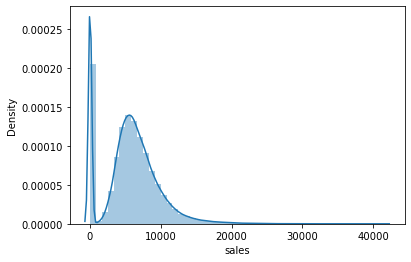

In [25]:
# Exemplo da distribuição das vendas(sales)
sns.distplot( df1["sales"])

/Users/raquelrocha/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

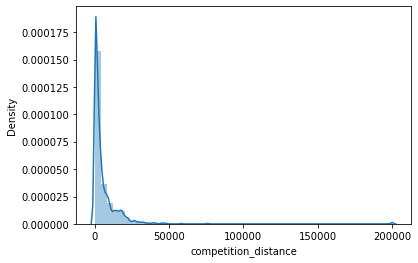

In [26]:
# Exemplo da distribuição da competition_distance
sns.distplot( df1["competition_distance"])

### 1.7.2 Categorical Attributes (Boxplot - vc tem medidas de desperção e tendência central em um local só ) 

In [27]:
# níveis cada variável categórica tem
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

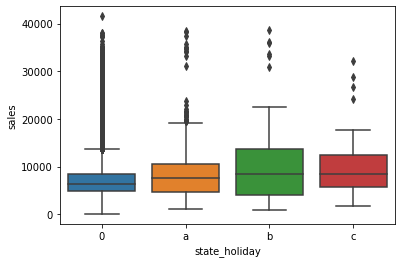

In [28]:
# Construir o boxplot
# Filtro 2 condições state_holiday e sales 
aux1 = df1[(df1["state_holiday"] !=0) & (df1["sales"] >0)]
# x(linha de referência ,nome da categoria) Y(o que vai medir, a dispersão data(dataframe)) 
sns.boxplot(x="state_holiday", y="sales", data=aux1)

<AxesSubplot:xlabel='assortment', ylabel='sales'>

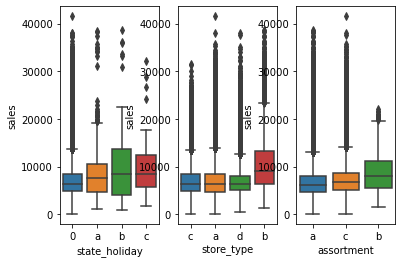

In [29]:
#colocando outras variáveis lado a lado
aux1 = df1[(df1["state_holiday"] !=0) & (df1["sales"] >0)]

plt.subplot (1, 3, 1)
sns.boxplot(x="state_holiday", y="sales", data=aux1)

plt.subplot (1, 3, 2)
sns.boxplot(x="store_type", y="sales", data=aux1)

plt.subplot (1, 3, 3)
sns.boxplot(x="assortment", y="sales", data=aux1)

# 2.0 Feature Engineering (Passo 2)
### (criar as variáveis, criar lista de hipóteses e validar as hipóteses)

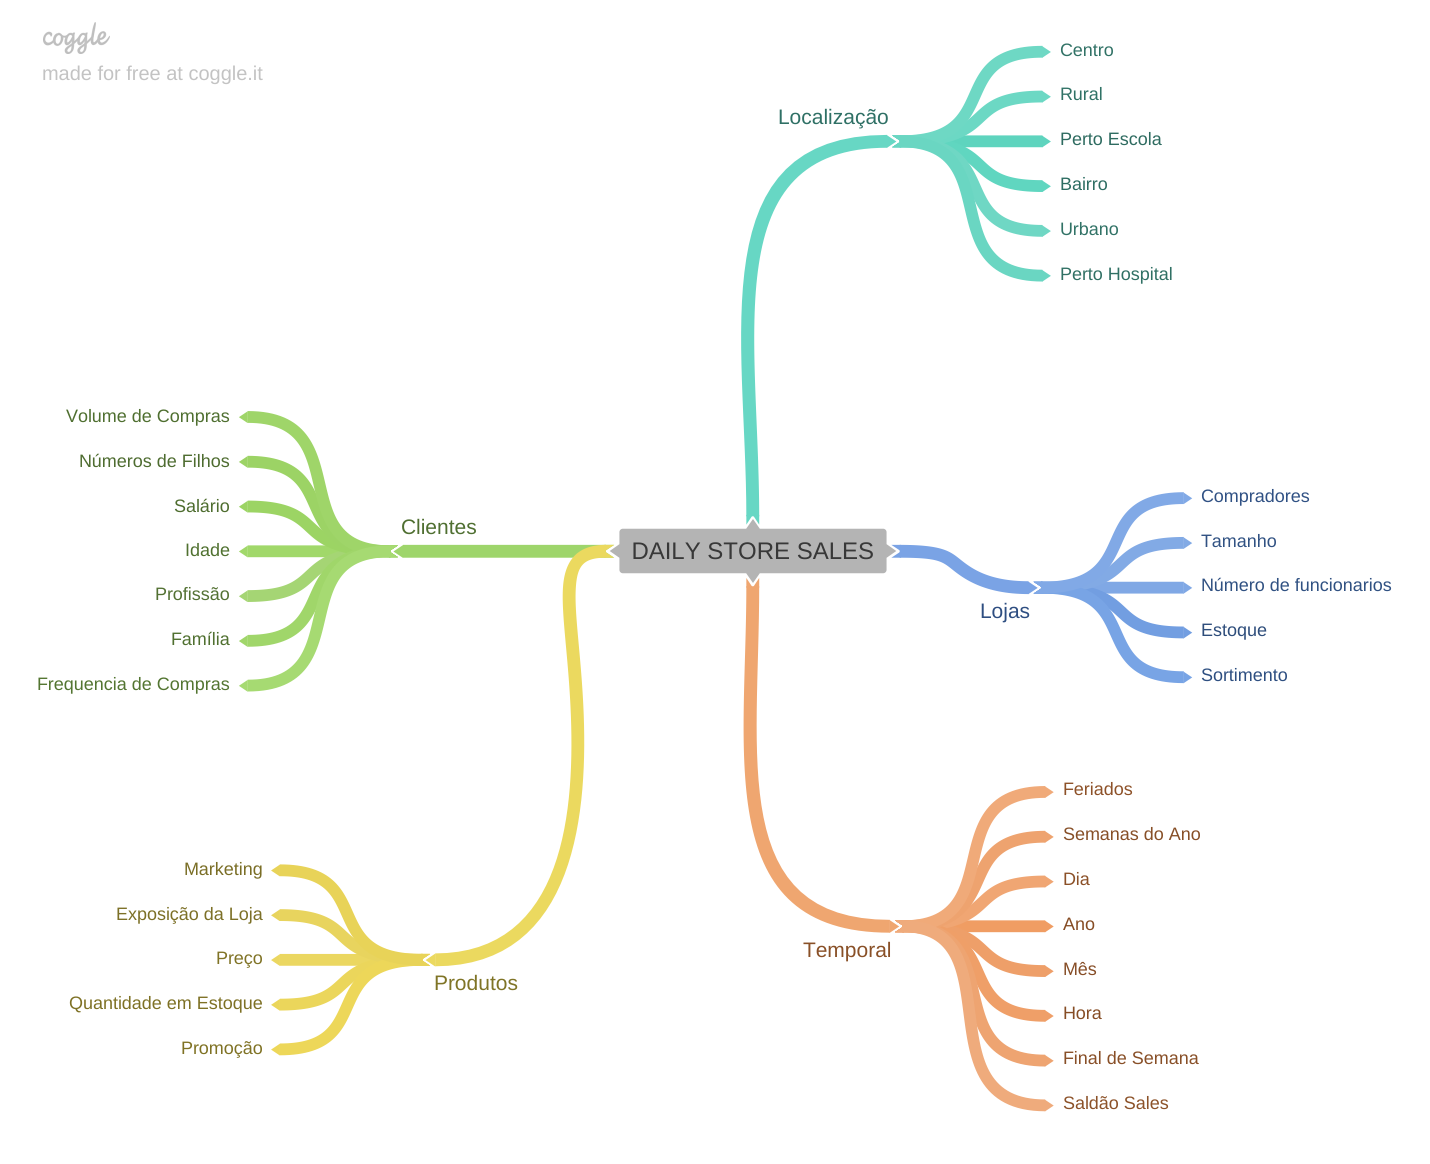

In [30]:
# aula 8 formar o mapa np=o stite coggle, salvar imagem e puchar ro arqvo jupyter
Image("MindMapHypothesis.png")

In [31]:
#Aula 10
df2 = df1.copy()

## 2.1 Criação das Hipóteses (aula 9)

### 2.1.1 Hipoteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.1.2 Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3 Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

### 2.2 Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

### 2.3 Feature Engineering (Aula 10 -Começamos copiando o arquivo df1 "df1.copy()")

In [32]:
# Variáveis a ser derivadas da variavel original Date 
# year 
df2["year"] = df2["date"].dt.year

# month
df2["month"] = df2["date"].dt.month

# day
df2["day"] = df2["date"].dt.day

# week of year
df2["week_of_year"] = df2["date"].dt.isocalendar().week

# year week (%Y ano, %W semana)
df2["year_week"] = df2["date"].dt.strftime("%Y-%W")


# competition since (esta em duas linhas nos dados, devemos juntar elas em uma só) day=1 para coeaçar no dia 1, considerando o mês como um todo
# método "datetime.datetime( year=x["competition_open_since_year"], month=x["competition_open_since_month"], day=1)"
# função em cima do método acima "df2.apply(lambda x: datetime.datetime( year=x["competition_open_since_year"], month=x["competition_open_since_month"], day=1)"
# se der problema de datetime not define, só importar o datetime
df2["competition_since"] = df2.apply( lambda x: datetime.datetime( year=x["competition_open_since_year"], month=x["competition_open_since_month"], day=1 ), axis=1 )
# diferença das duas (para conseguir o mês, P.S. subtrai o date comm o q vc quer)
df2["competition_time_month"] = ((df2["date"] - df2["competition_since"])/30).apply( lambda x: x.days).astype(int)

# promo since (juntar as duas informações(precisam estar como string),semana e o ano, e depois transformar no mês) (-) é para dar espaço entre as duas informações
df2["promo_since"] = df2["promo2_since_year"].astype(str) + "-" + df2["promo2_since_week"].astype(str)
# transformar novamente em data , (x + "-1", "%Y-%W-%w") = formato de resultadoano, semana do ano, semana de domingo a domingo (o w minúsculo)
df2["promo_since"] = df2["promo_since"].apply(lambda x: datetime.datetime.strptime (x + "-1", "%Y-%W-%w") - datetime.timedelta(days=7))
#subtrai as duas datas (subtrai o date comm o q vc quer)
df2["promo_time_week"]=((df2["date"] - df2["promo_since"])/7).apply(lambda x: x.days).astype(int)

# assortment, usar o apply para colocar em todas as linhas a função lambda, (a=basic, b=extra, c=extended (informações pegas no kaggle))
df2["assortment"] = df2["assortment"].apply(lambda x: "basic" if x =="a" else "extra" if x =="b" else "extended")

# state holiday usar o apply para colocar em todas as linhas a função lambda, (a=public holiday, b=easter holiday, c=christmas (informações pegas no kaggle))
df2["state_holiday"] = df2["state_holiday"].apply(lambda x: "public_holiday" if x =="a" else "easter_holiday" if x =="b" else "christmas" if x=="c" else "regular_day")



In [33]:
# Rodar as colunas para ver os codigos feitos anterior
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Filtragem de Variáveis (Passo 3) Aula11

In [34]:
df3 = df2.copy()

In [35]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das linhas
### começa com esse para diminuir volume dos dados que irá trabalhar.

In [36]:
# o que iremos filtrar ("open" != 0 "sales" > 0)
df3 = df3[(df3["open"] != 0) & (df3["sales"] > 0)]

## 3.2 Seleção das colunas

In [37]:
#o que não queremos ("customers", "open", "promo_interval", "month_map")
cols_drop = ["customers", "open","promo_interval", "month_map"]
# deletar (classe pandas "drop")
df3 = df3.drop(cols_drop,axis=1)

In [38]:
#verificar
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Análise Exploratória dos Dados - EDA (Passo 4)
### objetivos da análise exploratória dos dados

In [39]:
df4 = df3.copy()

## 4.1 Análise univariada

### 4.1.1 Responde variable

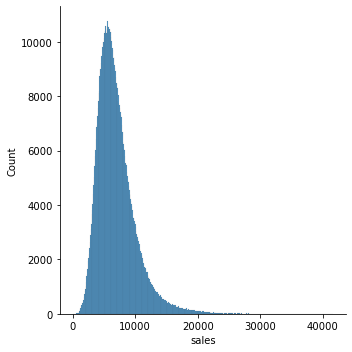

In [40]:
# distribuição das variáveis pode usar tanto "displot" quanto "histplot"
sns.displot(df4["sales"])

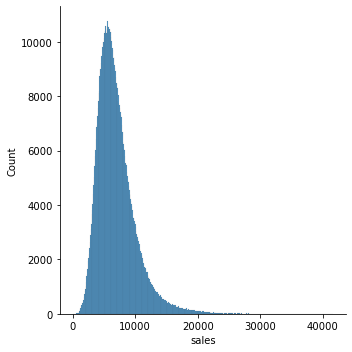

In [41]:
# se usar o "kde" mostra um histograma (ver pq não apareceu)
sns.displot(df4["sales"], kde=False)

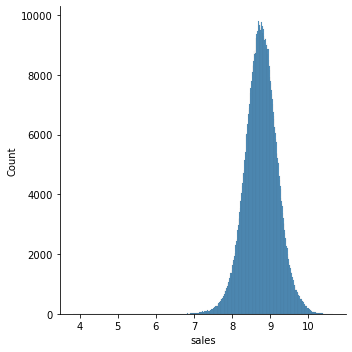

In [42]:
# formas de transformar o gráfico mais próximo de uma Distribuição normal
# pode usar bloxpot, exponencial
sns.displot(np.log (df4["sales"]))


### 4.1.2 Numerical variable

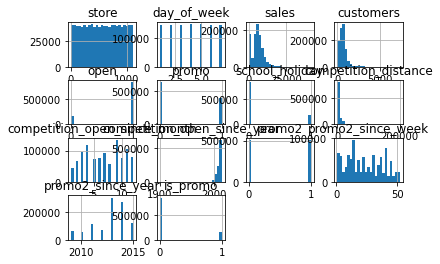

In [43]:
# plotar histograma de todas as variáveis numéricas
# Bins = Cada caixa, reatanguulo que vc coloca alguns dados agrupados
# ";" para não ficar mostrando a leitura dos dados antes do gráfico
num_attributes.hist(bins=25);

### 4.1.2 Categorical variable
#### p.s. tem muito sobre na internet de como transformar a categórica em númerica.

In [44]:
# contar quantas linhas tenho em cada uma das variávies categóricas
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [45]:
# para ficar apenas com os tipos de variáveis originais
df4["state_holiday"].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [46]:
# para ficar apenas com os tipos de variáveis originais
df4["store_type"].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

In [47]:
# para ficar apenas com os tipos de variáveis originais
df4["assortment"].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

/Users/raquelrocha/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/raquelrocha/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/raquelrocha/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpreta

<AxesSubplot:xlabel='sales', ylabel='Density'>

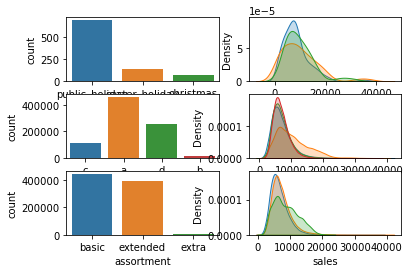

In [48]:
# as duas que não usamos são variáveis auxiliares que usamos para derivar outras
#aqui queremos saber o tipo de feriado que impacta mais


# state_holiday

# filtrar para ver melhor os dados, já que "regular day" possui muito mais infos que as demais variáveis de feriado (mais vendas)
# "sns.countplot(df4["state_holiday"])"
# esse faz uma especie de grid, matriz, para que os gráficos fiquem lado a lado (qtd por linhas, qtd por coluna, posição)
plt.subplot(3,2,1)

a = df4[df4["state_holiday"] != "regular_day"]
sns.countplot(a["state_holiday"])

# ver somente "public_holiday" na variável sales, shade deixa o gráfico mais transparente para sobrepor dois gráficos e ver melhor as comparações
plt.subplot(3,2,2)
sns.kdeplot (df4[df4["state_holiday"] == "public_holiday"]["sales"], label="public_holiday", shade=True)
sns.kdeplot (df4[df4["state_holiday"] == "easter_holiday"]["sales"], label="easter_holiday", shade=True)
sns.kdeplot (df4[df4["state_holiday"] == "christmas"]["sales"], label="christmas", shade=True)


# o que fez acima, replicar para as variáveis abaixo


# store_type
plt.subplot(3,2,3)
sns.countplot(df4["store_type"])

# ver somente "store_type" na variável sales, shade deixa o gráfico mais transparente para sobrepor dois gráficos e ver melhor as comparações
plt.subplot(3,2,4)
sns.kdeplot (df4[df4["store_type"] == "a"]["sales"], label="a", shade=True)
sns.kdeplot (df4[df4["store_type"] == "b"]["sales"], label="b", shade=True)
sns.kdeplot (df4[df4["store_type"] == "c"]["sales"], label="c", shade=True)
sns.kdeplot (df4[df4["store_type"] == "d"]["sales"], label="d", shade=True)


# assortment

plt.subplot(3,2,5)
sns.countplot(df4["assortment"])

# ver somente "assortment" na variável sales, shade deixa o gráfico mais transparente para sobrepor dois gráficos e ver melhor as comparações
plt.subplot(3,2,6)
sns.kdeplot (df4[df4["assortment"] == "basic"]["sales"], label="basic", shade=True)
sns.kdeplot (df4[df4["assortment"] == "extended"]["sales"], label="extended", shade=True)
sns.kdeplot (df4[df4["assortment"] == "extra"]["sales"], label="extra", shade=True)


## 4.2 Análise bivariada
### Análise exploratória de dados - Parte I, II e III

##### H1 Lojas com maior sortimentos deveriam vender mais.
***falso*** lojas com maior sortimento(assortment) vendem menos

<AxesSubplot:xlabel='year_week'>

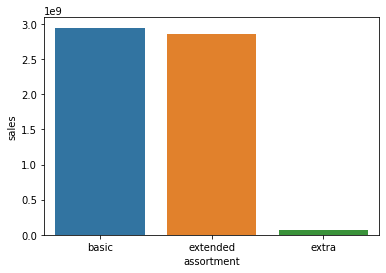

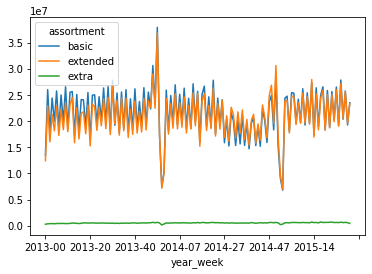

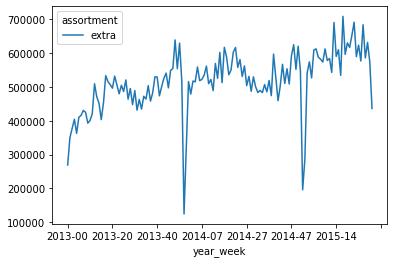

In [49]:
# agrupar o sales no assortment
aux1 = df4[["assortment","sales"]].groupby("assortment").sum().reset_index()
sns.barplot(x="assortment",y="sales",data=aux1);

# veremos por dia para ver se houve mudança de comportamento do cliente
aux2 = df4[["year_week","assortment","sales"]].groupby(["year_week","assortment"]).sum().reset_index()
#aqui estamos fazendo um pivot para ver cada linhas de forma única em cima dos valores dos dados 
aux2.pivot(index="year_week", columns="assortment", values="sales").plot()

#filtrar para pegar a linha do extra 
aux3 = aux2[aux2["assortment"]=="extra"]
aux3.pivot(index="year_week", columns="assortment", values="sales").plot()


##### H2 Lojas com competidores mais próximos deveriam vender menos.
***falso*** lojas com competidores mais próximos vendem mais

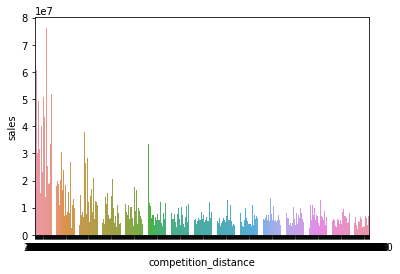

In [50]:
aux1 = df4[["competition_distance", "sales"]].groupby("competition_distance").sum().reset_index()
sns.barplot(x="competition_distance",y="sales",data=aux1);


In [51]:
# faremos bin nesse caso para ficar mais fácil de ver os dados
# lista de 0 a 20000, em grupos de 1000 em 1000aux1 = df4[["competition_distance", "sales"]].groupby("competition_distance").sum().reset_index()

bins = list(np.arange(0,20000,1000))
# para saber em qual grupo os valores se encaixam, usando o método cut do pandas
aux1["competition_distance_binned"] = pd.cut(aux1["competition_distance"],bins=bins)


In [52]:
aux1.sample(4)

,competition_distance,sales,competition_distance_binned
566,17080.0,2807854,"(17000, 18000]"
332,4630.0,4885211,"(4000, 5000]"
412,6970.0,10000457,"(6000, 7000]"
368,5470.0,4005216,"(5000, 6000]"


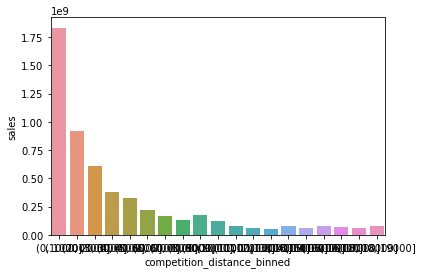

In [53]:
#resultado da Bin que foi feita
aux1 = df4[["competition_distance", "sales"]].groupby("competition_distance").sum().reset_index()

bins = list(np.arange(0,20000,1000))

aux1["competition_distance_binned"] = pd.cut(aux1["competition_distance"], bins=bins)
aux2 = aux1[["competition_distance_binned", "sales"]].groupby("competition_distance_binned").sum().reset_index()

sns.barplot(x="competition_distance_binned", y="sales", data=aux2);


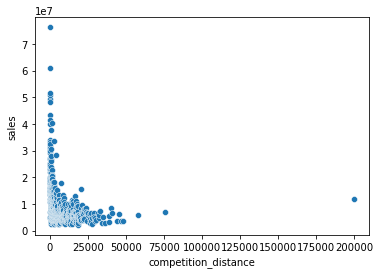

In [54]:
# validar se a variável é importante para o modelo
# gráfico de pontos, para ver a distribuição (concentração) dos valores
aux1 = df4[["competition_distance", "sales"]].groupby("competition_distance").sum().reset_index()
sns.scatterplot(x="competition_distance",y="sales",data=aux1);


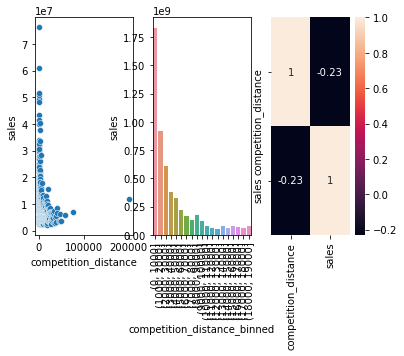

In [55]:
# gráfico para ver a correlação entre "competition_distance e sales"
aux1 = df4[["competition_distance", "sales"]].groupby("competition_distance").sum().reset_index()

plt.subplot (1,3,1)
sns.scatterplot(x="competition_distance",y="sales",data=aux1);

plt.subplot (1,3,2)
bins = list(np.arange(0,20000,1000))
aux1["competition_distance_binned"] = pd.cut(aux1["competition_distance"], bins=bins)
aux2 = aux1[["competition_distance_binned", "sales"]].groupby("competition_distance_binned").sum().reset_index()
sns.barplot(x="competition_distance_binned", y="sales", data=aux2);
plt.xticks (rotation = 90);

# plot que mede a força da correlação
plt.subplot (1,3,3)
x=sns.heatmap (aux1.corr(method="pearson"),annot=True);
#rodar os numeros 90 graus para ler melhor (não deixar amontoados)
plt.xticks (rotation = 90);

##### H3 Lojas com competidores à mais tempo deveriam vendem mais.
***falso*** lojas com competidores a mais tempo vendem menos

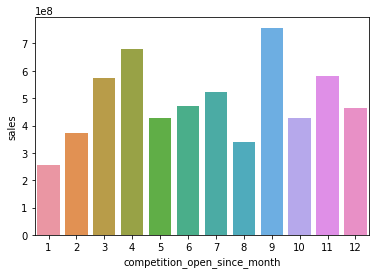

In [56]:
aux1 = df4[["competition_open_since_month","sales"]].groupby("competition_open_since_month").sum().reset_index()
sns.barplot(x="competition_open_since_month", y="sales", data=aux1);


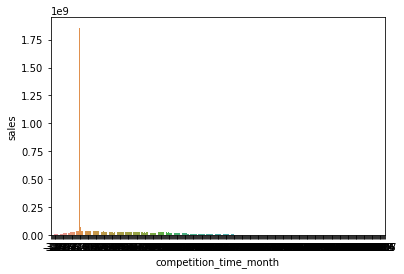

In [57]:
# gráfico ruim de ver
aux1 = df4[["competition_time_month","sales"]].groupby("competition_time_month").sum().reset_index()
sns.barplot(x="competition_time_month", y="sales", data=aux1);


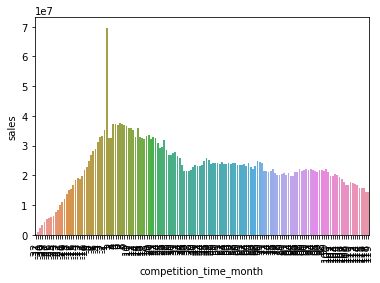

In [58]:
# gráfico com melhor visualização
aux1 = df4[["competition_time_month","sales"]].groupby("competition_time_month").sum().reset_index()
#ver os 120 primeiros meses de competicão e filtrar os competidores que tem diferente de 0
aux2 = aux1[(aux1["competition_time_month"] <120) & (aux1["competition_time_month"] != 0)]
sns.barplot(x="competition_time_month", y="sales", data=aux2);
plt.xticks(rotation=90);


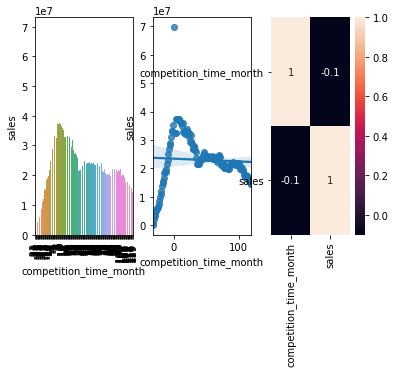

In [59]:
# plot que mede a força da correlação
plt.subplot (1,3,1)
aux1 = df4[["competition_time_month","sales"]].groupby("competition_time_month").sum().reset_index()
aux2 = aux1[(aux1["competition_time_month"] <120) & (aux1["competition_time_month"] != 0)]
sns.barplot(x="competition_time_month", y="sales", data=aux2);
plt.xticks(rotation=90);

#comportamento de crescimento e decaimento
plt.subplot (1,3,2)
sns.regplot(x="competition_time_month", y="sales", data=aux2);

# plot de correlação
plt.subplot (1,3,3)
x=sns.heatmap (aux1.corr(method="pearson"),annot=True);


##### H4 Lojas com promoções ativas por mais tempo deveriam vender mais.
***falso*** lojas com promoções ativas por mais tempo vendem menos, depois de um certo periodo de promoção

In [60]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


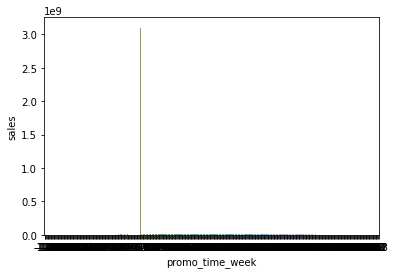

In [61]:
# gráfico ruim de analisar.
aux1 = df4[["promo_time_week", "sales"]].groupby("promo_time_week").sum().reset_index()
sns.barplot (x="promo_time_week", y="sales", data=aux1);



In [ ]:
# aqui iremos particionar as informações para ver melhor o gráfico
# P.S. Para jogar os dados no Modelo (ML) não particiona as informações, tem que colocar os dados inteiros para testar e treinar o modelo
aux1 = df4[["promo_time_week", "sales"]].groupby("promo_time_week").sum().reset_index()

plt.subplot(2,2,1)
aux2 = aux1[aux1["promo_time_week"]>0] #promo extendido
sns.barplot (x="promo_time_week", y="sales", data=aux2);
plt.xticks(rotation=90);

# ver gráfico que mostra a tendencia decrescente
plt.subplot(2,2,2)
sns.regplot (x="promo_time_week", y="sales", data=aux2);

plt.subplot(2,2,3)
aux3 = aux1[aux1["promo_time_week"]<0] #promo regular
sns.barplot (x="promo_time_week", y="sales", data=aux3);
plt.xticks(rotation=90);

# ver gráfico que mostra a tendencia crescente
plt.subplot(2,2,4)
sns.regplot (x="promo_time_week", y="sales", data=aux3);



In [ ]:
#como teremos 5 graficos devemos usar o GridSpec

# P.S. Para jogar os dados no Modelo (ML) não particiona as informações, tem que colocar os dados inteiros para testar e treinar o modelo
# aqui iremos particionar as informações para ver melhor o gráfico
aux1 = df4[["promo_time_week", "sales"]].groupby("promo_time_week").sum().reset_index()

# esse código forma as posições dos gráficos de forma diferente do subplot(em quadrados/matriz)
grid = gridspec.GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1["promo_time_week"]>0] #promo extendido
sns.barplot (x="promo_time_week", y="sales", data=aux2);
plt.xticks(rotation=90);

# ver gráfico que mostra a tendencia decrescente
plt.subplot(grid[0,1])
sns.regplot (x="promo_time_week", y="sales", data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1["promo_time_week"]<0] #promo regular
sns.barplot (x="promo_time_week", y="sales", data=aux3);
plt.xticks(rotation=90);

# ver gráfico que mostra a tendencia crescente
plt.subplot(grid[1,1])
sns.regplot (x="promo_time_week", y="sales", data=aux3);

# ver a força da correlação
# aqui quero que ocupe as duas últimas linhas, por isso colocou de 2 para frente (:,2)

plt.subplot(grid[:,2])
sns.heatmap (aux1.corr(method="pearson"), annot=True); #annot=True mostra os valores no gráfico de correlação


##### <s> H5. Lojas com mais dias de promoção deveriam vender mais. </s> será validada na segunda etapa do CRISP

##### H6 Lojas com mais promoções consecutivas deveriam vender mais.
***falso*** lojas com mais promoções consecutivas vendem menos

In [ ]:
df4[["promo", "promo2", "sales"]].groupby(["promo", "promo2"]).sum().reset_index()

In [ ]:
# vendas das lojas q tiveram nos dois periodos de promoção
# ver se lojas que entraram na promo tradicional teve mudança no comportamento ao entrar na promo extendida
aux1 = df4[(df4["promo"]==1) & (df4["promo2"]== 1)][["year_week", "sales"]].groupby("year_week").sum().reset_index()
aux1.plot()


In [ ]:
# vendas das lojas q tiveram nos dois periodos de promoção
# ver se lojas que entraram na promo tradicional (1) teve mudança no comportamento ao entrar na promo extendida(0)
aux1 = df4[(df4["promo"]==1) & (df4["promo2"]== 1)][["year_week", "sales"]].groupby("year_week").sum().reset_index()
ax = aux1.plot()

# aqui vamos analisar apenas as lojas que tiveram periodo da promo extendido
aux2 = df4[(df4["promo"]==1) & (df4["promo2"]== 0)][["year_week", "sales"]].groupby("year_week").sum().reset_index()
aux2.plot(ax=ax)#esse ax faz com que plot o grafico no mesmo grid

# faz a legenda do gráfico
ax.legend(labels=["Tradicional 7 Extendida", "Extendida"]);


##### H77. Lojas abertas durante o feriado de Natal deveriam vender mais.
***falso*** lojas abertas durante o feriado de Natal vendem menos

In [ ]:
# gráfico ruim de analsar
aux1 = df4[["state_holiday", "sales"]].groupby("state_holiday").sum().reset_index()
sns.barplot(x="state_holiday", y="sales", data=aux1);


In [ ]:
# aqui retiraremos os "regular_day" para trabalhar só com os feriados
aux = df4[df4["state_holiday"]!= "regular_day"]
aux1 = aux[["state_holiday", "sales"]].groupby("state_holiday").sum().reset_index()
sns.barplot(x="state_holiday", y="sales", data=aux1);


In [ ]:
#calcular quantidade de vendas ao ano (para saber se o natal já vendeu mais em algum periodo)
# aqui retiraremos os "regular_day" para trabalhar só com os feriados
aux = df4[df4["state_holiday"]!= "regular_day"]

plt.subplot(1,2,1)
aux1 = aux[["state_holiday", "sales"]].groupby("state_holiday").sum().reset_index()
sns.barplot(x="state_holiday", y="sales", data=aux1);

plt.subplot(1,2,2)
aux2 = aux[["year", "state_holiday", "sales"]].groupby(["year", "state_holiday"]).sum().reset_index()
sns.barplot(x="year", y="sales", hue="state_holiday", data=aux2);


##### H8. Lojas deveriam vender mais ao longo dos anos.
***falso*** lojas vendem menos ao longo do ano

In [ ]:
aux1 = df4[["year", "sales"]].groupby("year").sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x="year", y="sales", data=aux1);

#tendência
plt.subplot(1,3,2)
sns.regplot(x="year", y="sales", data=aux1);

#correlação (pegamos valores fechados, por isso nesse caso deu correlação alta, pois não tem 2015 fechado)
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = "pearson"), annot=True); #annot=True para ver os valores


##### H9 Lojas deveriam vender mais no segundo semestre do ano.
***falso*** lojas vendem menos no segundo semestre do ano

##### H10 Lojas deveriam vender mais depois do dia 10 de cada mês.
***verdadeira*** lojas vendem mais depois do dia 10

In [ ]:
# só para olhar
aux1["before_after"] = aux1["day"].apply(lambda x:"before_10_days" if x <= 10 else "after_10_days")
aux1.head(15)

In [ ]:
aux1 = df4[["day", "sales"]].groupby("day").sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x="day", y="sales", data=aux1);

#tendência
plt.subplot(2,2,2)
sns.regplot(x="day", y="sales", data=aux1);

#correlação (pegamos valores fechados, por isso nesse caso deu correlação alta, pois não tem 2015 fechado)
plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method = "pearson"), annot=True); #annot=True para ver os valores

aux1["before_after"] = aux1["day"].apply(lambda x:"before_10_days" if x <= 10 else "after_10_days")
aux2 = aux1[["before_after", "sales"]].groupby("before_after").sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x="before_after", y="sales", data=aux2);


In [ ]:
aux1 = df4[["month", "sales"]].groupby("month").sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x="month", y="sales", data=aux1);

#tendência
plt.subplot(1,3,2)
sns.regplot(x="month", y="sales", data=aux1);

#correlação (pegamos valores fechados, por isso nesse caso deu correlação alta, pois não tem 2015 fechado)
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = "pearson"), annot=True); #annot=True para ver os valores


##### H11 Lojas deveriam vender menos aos finais de semana.
***verdadeira*** lojas vendem menos aos finais de semana

In [ ]:
# para relembrar os nomes das colunas
df4.head()

In [ ]:
aux1 = df4[["day_of_week", "sales"]].groupby("day_of_week").sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x="day_of_week", y="sales", data=aux1);

#tendência
plt.subplot(1,3,2)
sns.regplot(x="day_of_week", y="sales", data=aux1);

#correlação (pegamos valores fechados, por isso nesse caso deu correlação alta, pois não tem 2015 fechado)
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = "pearson"), annot=True); #annot=True para ver os valores


##### H12 Lojas deveriam vender menos durante os feriados escolares.
***verdadeira*** lojas vendem menos durante os feriados escolares, exceto os meses de Julho e Agosto (que vendem mais portano Falso)

In [ ]:
aux1 = df4[["school_holiday", "sales"]].groupby("school_holiday").sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x="school_holiday", y="sales", data=aux1);

aux2 = df4[["month", "school_holiday", "sales"]].groupby(["month", "school_holiday"]).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x="month", y="sales", hue="school_holiday", data=aux2);



## 4.2.1 Resumo das Hipóteses

In [ ]:
from tabulate import tabulate

In [ ]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H6', 'Falsa', 'Baixa'],
['H7', 'Falsa', 'Media'],
['H8', 'Falsa', 'Alta'],
['H9', 'Falsa', 'Alta'],
['H10', 'Verdadeira', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

## 4.3 Análise multivariada

### 4.3.1 Numerical Attributes

In [ ]:
# aqui apenas para olhar se temos variáveis numéricas
num_attributes.head()

In [ ]:
# fazer correlação entre todas as variáveis
# p.s Método de Pearson é para fazer a correlação entre duas variáveis numéricas 
correlation=num_attributes.corr(method="pearson")
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorical Attributes

In [ ]:
# p.s Método de Cramer V é para fazer a correlação entre variáveis numéricas + categóricas ou entre variáveis categóricas
# aqui para ver se só temos variáveis categóricas
# aqui estou pegando o dataset da análise descritiva, então está defasado
cat_attributes.head()

In [ ]:
# para pegar o dataset mais atual, incluindo apenas variaveis q se apresentam como object
# usaremos 3 colunas, o year se apresenta como object, mas ele é uma data
a = df4.select_dtypes (include = "object")
a.head()

In [ ]:
# como funciona, pega duas variáveis categóricas que queria fazer a correlação
# monta uma tabela onde vc tem nas linhas o state holiday e nas counas o store type
pd.crosstab(a["state_holiday"],a["store_type"])


In [ ]:
# armazenando na variável cm
cm = pd.crosstab(a["state_holiday"],a["store_type"]).to_numpy()


In [ ]:
# teste para validar as linhas estão pegando, basta trocar o nome da linha que quer ver
# Basicamente uma matriz de confusão(cm) ou tabela de contingência
a[(a["state_holiday"] == "christmas") & (a["store_type"] == "a")]


In [ ]:
# esse método já vem pronto para calcular, vem da biblioteca scipy
chi2 = ss.chi2_contingency(cm)


In [ ]:
# aqui estamos olhando o primeiro valor, de teste por isso colocou [0]
# fórmula
# vamos aplicar ela como uma função para aplicarmos mais de uma vez
chi2 = ss.chi2_contingency(cm)[0]

n = cm.sum() #soma de todos os valores, usando a matriz de confusão

r,k =cm.shape #numero de linhas e colunas


In [ ]:
# aqui vê a reposta, 4 resultados(1 teste, 2 p valor, 3 grau de liberdade 4 tabela de frequeência)
chi2

In [ ]:
# Cramer V divisão sobre dois termos (quiquadrado/n e menor valor entre a coluna e linha) (quiquadrado, n=total de observação, k=números de coluna, r=números de linha)
# diferente do pearson que a correlação vai de -1 a 1, o v crame só vai de 0 a 1, não vemos correlação negativa
v = np.sqrt ((chi2/n) / (min(k-1,r-1)))

In [ ]:
v

In [ ]:
# aqui estamos olhando o primeiro valor, de teste por isso colocou [0]
# fórmula
# vamos aplicar ela como uma função para aplicarmos mais de uma vez
def cramer_v(x,y):
    cm = pd.crosstab(x,y).to_numpy()
    n = cm.sum() #soma de todos os valores, usando a matriz de confusão
    r,k =cm.shape #numero de linhas e colunas
    chi2 = ss.chi2_contingency(cm)[0]
    
    chi2corr = max(0, chi2 - (k-1)+(r-1)/(n-1)) # p.s. cramer tem alto viés em relacnao ao estimador (precisa fazer uma correção por causa disso) tende a superestimar
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))
  

In [ ]:
# fazendo uma tabela
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
'store_type': [a4, a5, a6],
'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )

In [ ]:
# correlacnao entre as variáveis categóricas
sns.heatmap( d, annot=True )